# Time Series EDA

In [29]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

warnings.filterwarnings("ignore")

#### Do your work for this exercise in a notebook named explore. Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

#### For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

In [30]:
df = pd.read_csv('opsd_german_daily.csv')

In [31]:
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df.tail()

,Consumption,Wind,Solar,Wind+Solar,Month,Year,Day
Date,,,,,,,
2017-12-27,1263.94091,394.507,16.530,411.037,December,2017,Wednesday
2017-12-28,1299.86398,506.424,14.162,520.586,December,2017,Thursday
2017-12-29,1295.08753,584.277,29.854,614.131,December,2017,Friday
2017-12-30,1215.44897,721.247,7.467,728.714,December,2017,Saturday
2017-12-31,1107.11488,721.176,19.980,741.156,December,2017,Sunday


In [32]:
df.index.min() , df.index.max()

(Timestamp('2006-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [33]:
train = df.loc[:'2015']
val = df.loc['2016']
test = df.loc['2017']
train.shape, val.shape, test.shape

((3652, 7), (366, 7), (365, 7))

## Does month affect consumption?

In [34]:
Monthly_consumption = train.groupby('Month').Consumption.sum()
Monthly_consumption

Month
April        386614.725
August       384865.393
December     422095.410
February     407378.279
January      440597.138
July         390876.360
June         375662.162
March        425157.386
May          388086.303
November     424366.962
October      417988.389
September    393063.957
Name: Consumption, dtype: float64

In [35]:
Monthly_consumption = Monthly_consumption.reindex(index=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
Monthly_consumption

Month
January      440597.138
February     407378.279
March        425157.386
April        386614.725
May          388086.303
June         375662.162
July         390876.360
August       384865.393
September    393063.957
October      417988.389
November     424366.962
December     422095.410
Name: Consumption, dtype: float64

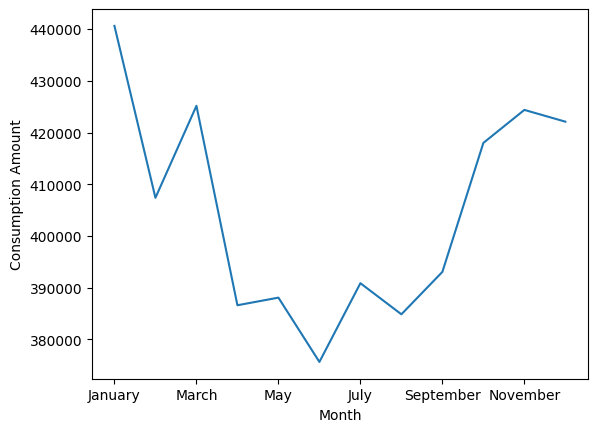

In [36]:
Monthly_consumption.plot()
plt.ylabel('Consumption Amount')

plt.show()

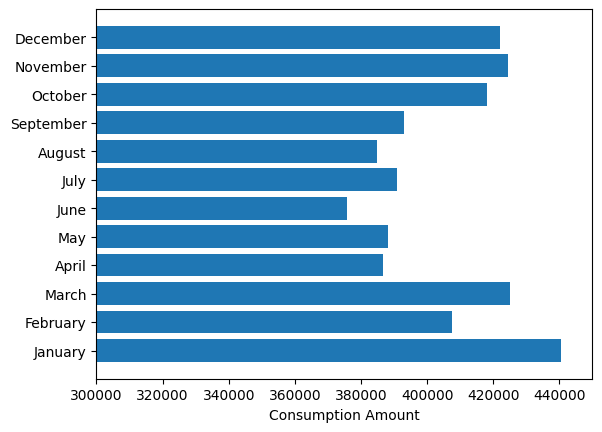

In [37]:
plt.barh(width=Monthly_consumption, y=Monthly_consumption.index)
plt.xlim(300_000, 450_000)
plt.xlabel('Consumption Amount')
plt.show()

### Yes, month does affect consumption.

## Does Month affect Wind+Solar?

In [38]:
Monthly_WS_prod = train.groupby('Month')['Consumption'].sum()
Monthly_WS_prod

Month
April        386614.725
August       384865.393
December     422095.410
February     407378.279
January      440597.138
July         390876.360
June         375662.162
March        425157.386
May          388086.303
November     424366.962
October      417988.389
September    393063.957
Name: Consumption, dtype: float64

Monthly_WS_prod = Monthly_WS_prod.reindex(index=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
Monthly_WS_prod

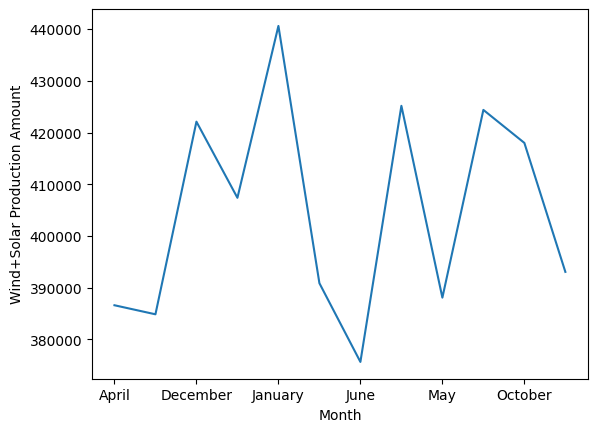

In [39]:
Monthly_WS_prod.plot()
plt.ylabel('Wind+Solar Production Amount')
plt.show()

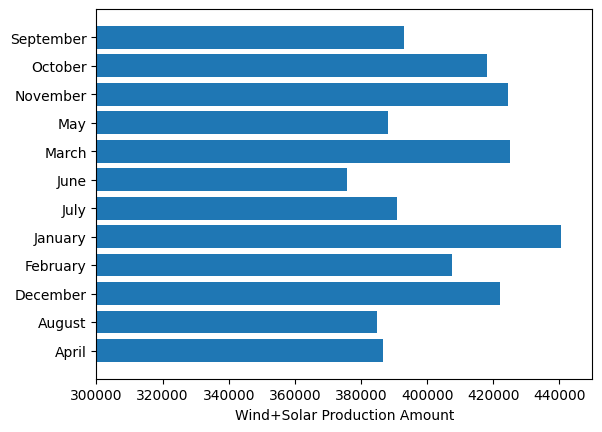

In [40]:
plt.barh(width=Monthly_WS_prod, y=Monthly_WS_prod.index)
plt.xlabel('Wind+Solar Production Amount')
plt.xlim(300_000, 450_000)
plt.show()

###  Yes, month does affect Wind+Solar production.

## Does consumption go up on certain days of the week?

In [41]:
Daily_cons_sums = train.groupby('Day').Consumption.sum()

In [42]:
Daily_cons_sums = Daily_cons_sums.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
Daily_cons_sums

Day
Monday       721516.725
Tuesday      741000.790
Wednesday    743181.048
Thursday     736576.095
Friday       721510.229
Saturday     621505.983
Sunday       571461.594
Name: Consumption, dtype: float64

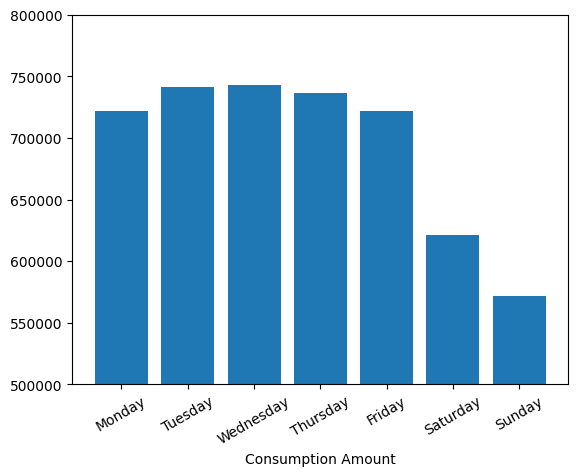

In [43]:
plt.bar(x=Daily_cons_sums.index, height=Daily_cons_sums)
plt.xlabel('Consumption Amount')
plt.ylim(500_000, 800_000)
plt.xticks(rotation=30)
plt.show()

### Yes, consumption hits an all time low on the weekends, especially Sundays and picks back up on Mondays.

## How does the target variable evolve with the passage of time?

In [44]:
Monthly_cons = train.resample('M').Consumption.mean()
Monthly_cons.head()

Date
2006-01-31    1461.442065
2006-02-28    1467.106893
2006-03-31    1418.649161
2006-04-30    1275.058900
2006-05-31    1253.488484
Freq: M, Name: Consumption, dtype: float64

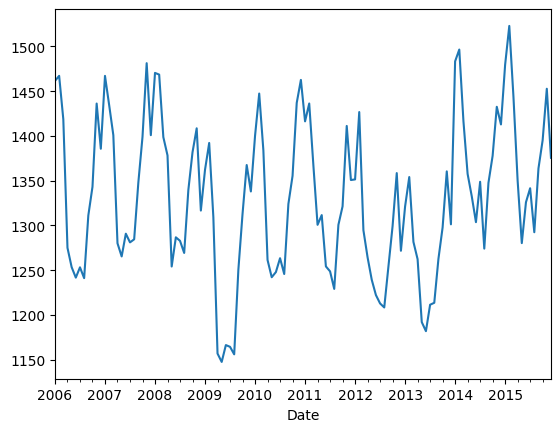

In [45]:
Monthly_cons.plot()
plt.show()

- A gradual annual growth in consumption is observed.
- Consumption exhibits seasonal peaks at the transition points between years, with troughs occurring toward the year's end.

### Creating lag features to help identify the correlation between the current amount of consumption and previous consumptions.

In [46]:
Daily_cons = train.resample('D').Consumption.sum()
Daily_cons.head()

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Freq: D, Name: Consumption, dtype: float64

## Weekly

In [47]:
Weekly_shift = pd.DataFrame({ 'Now': Daily_cons,
                             'One_week_out': Daily_cons.shift(-7)})
Weekly_shift.head()

,Now,One_week_out
Date,,
2006-01-01,1069.184,1207.985
2006-01-02,1380.521,1529.323
2006-01-03,1442.533,1576.911
2006-01-04,1457.217,1577.176
2006-01-05,1477.131,1553.280


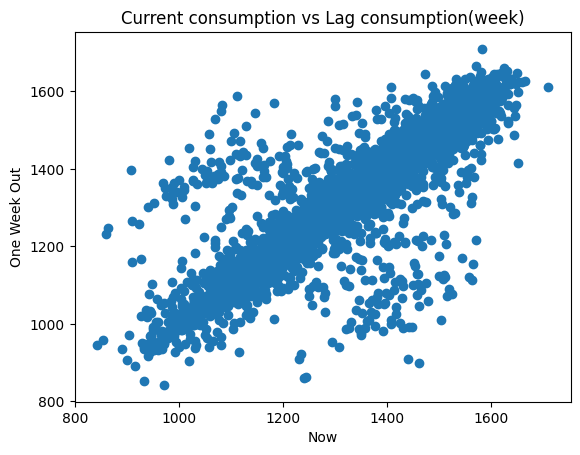

In [48]:
plt.scatter(x=Weekly_shift.Now, y=Weekly_shift.One_week_out)
plt.title('Current consumption vs Lag consumption(week)')
plt.xlabel('Now')
plt.ylabel('One Week Out')
plt.show()

## Monthly

In [49]:
Monthly_cons = pd.DataFrame({'Now': Daily_cons,
                             'One_Month_Out': Daily_cons.shift(-30)})
Monthly_cons.head()

,Now,One_Month_Out
Date,,
2006-01-01,1069.184,1575.129
2006-01-02,1380.521,1582.134
2006-01-03,1442.533,1595.717
2006-01-04,1457.217,1577.786
2006-01-05,1477.131,1366.322


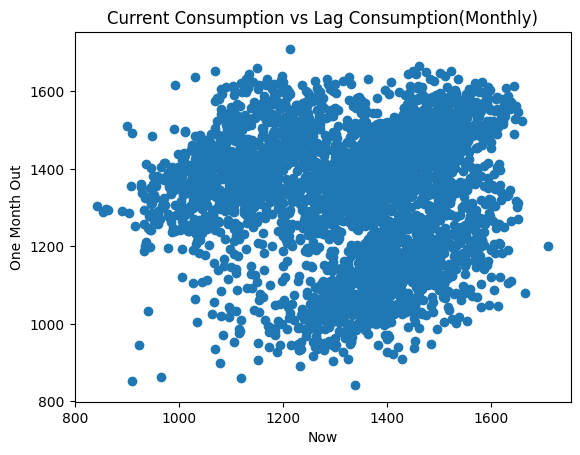

In [50]:
plt.scatter(x=Monthly_cons.Now, y=Monthly_cons.One_Month_Out)
plt.title('Current Consumption vs Lag Consumption(Monthly)')
plt.xlabel('Now')
plt.ylabel('One Month Out')
plt.show()

### Half Year

In [51]:
Bi_year_cons = pd.DataFrame({'Now': Daily_cons,
                             'Half_year_out': Daily_cons.shift(-182)})
Bi_year_cons.head()

,Now,Half_year_out
Date,,
2006-01-01,1069.184,997.896
2006-01-02,1380.521,1327.143
2006-01-03,1442.533,1356.526
2006-01-04,1457.217,1377.781
2006-01-05,1477.131,1377.990


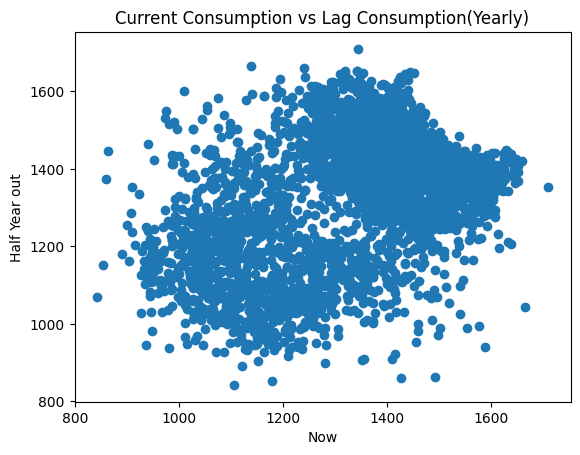

In [52]:
plt.scatter(x=Bi_year_cons.Now, y=Bi_year_cons.Half_year_out)
plt.title('Current Consumption vs Lag Consumption(Yearly)')
plt.xlabel('Now')
plt.ylabel('Half Year out')
plt.show()

## Understanding Data Persistence Over Time with an Auto Correlation Plot.

In [57]:
daily_cons = train.Consumption.resample('D').mean()
weekly_cons = train.Consumption.resample('W').mean()
monthly_cons = train.Consumption.resample('M').mean()

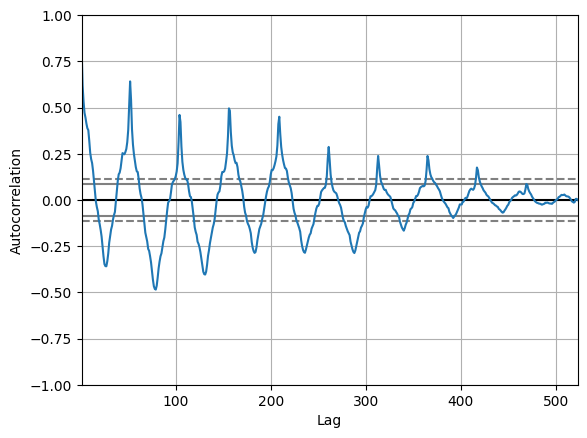

In [58]:
pd.plotting.autocorrelation_plot(weekly_cons)
plt.show()

## Trend, Seasonality, and Residual Analysis

In [55]:
result = sm.tsa.seasonal_decompose(daily_cons)
result1 = sm.tsa.seasonal_decompose(weekly_cons)
result2 = sm.tsa.seasonal_decompose(monthly_cons)

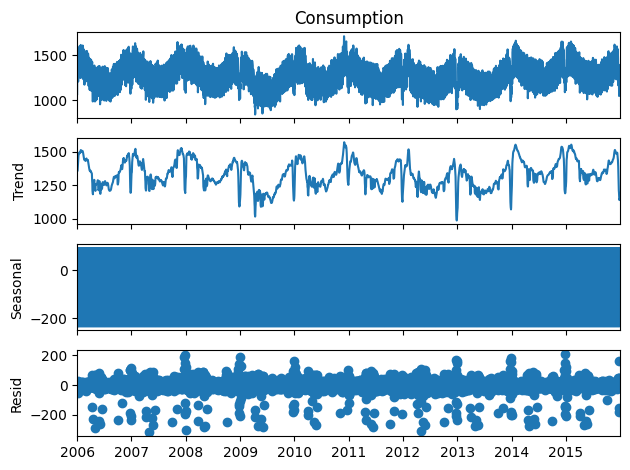

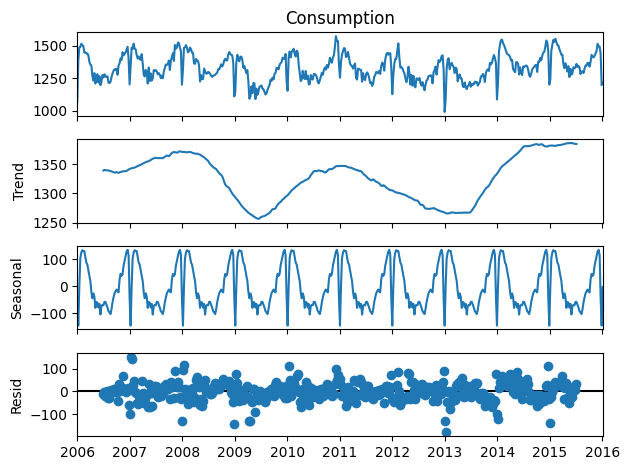

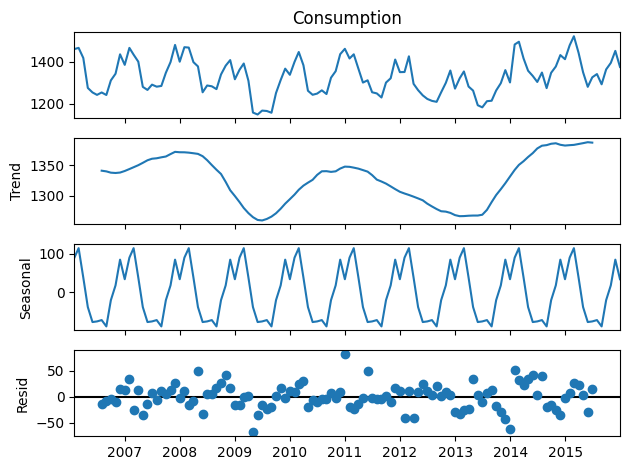

In [56]:
result.plot()
result1.plot()
result2.plot()
plt.show()